In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model # 함수를 이용해서 신경망 모델을 만들기 위해 import 한다.
from tensorflow.keras.layers import Input # 함수형 신경망에서 입력 데이터 형태를 지정하기 위해 import 한다.
from tensorflow.keras.layers import Conv2D # 신경망에 추가할 합성곱 레이어를 생성하기 위해 import 한다.
from tensorflow.keras.layers import MaxPool2D # 신경망에 추가할 맥스 풀링 레이어를 생성하기 위해 import 한다.
# 다운 샘플링(Down Sampling)은 이미지의 크기를 줄여가며 특징을 추출하는 과정이고 업 샘플링(Up Sampling)은
# 다운 샘플링된 이미지를 원래 이미지로 복원하는 과정이다.
from tensorflow.keras.layers import UpSampling2D # 신경망에 업 샘플링 레이어를 추가하기 위해 import 한다.

오토 인코더(Auto Encoder)

오토 인코더는 신경망의 한 종류로 데이터를 코드(Code)라고 부르는 은닉층으로 인코딩하는 인코더(Encoder) 부분과 인코딩된 코드를 다시 디코딩하는 디코더(Decoder)로 구성되어 있다. 인코딩 원래 데이터를 차원 축소하는 것을 의미하고, 디코딩은 차원 축소된 데이터를 다시 원래 데이터로 복원하는 것을 의미한다.

<img src="./autoEncoder_1.png" width="700"/>

오토 인코더의 시작은 차원 축소와 관련이 있는데 초기 인코더는 주성분 분석과 같은 차원 축소를 위해 사용했지만, 현재는 데이터 생성 모형으로도 쓰인다.

오토 인코더를 이용해 손글씨 이미지 데이터의 노이즈를 없애본다.

In [2]:
# 일관된 결과값이 나오도록 numpy와 tensorflow의 seed를 설정한다.
np.random.seed(0)
tf.random.set_seed(0)

오토 인코더에 사용할 오리지널 데이터 준비

In [3]:
# 손글씨 데이터 셋을 학습 데이터와 테스트 데이터로 저장한다.
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
# 오리지널 데이터 확인
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


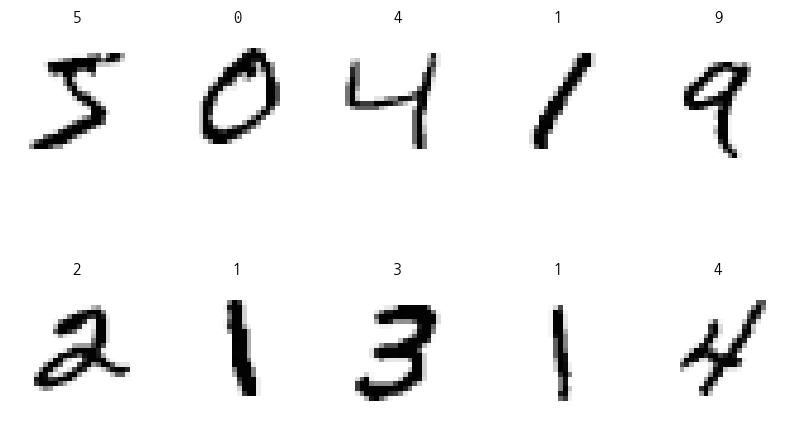

In [4]:
# 오리지널 데이터 시각화
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='Greys')
    plt.axis('off')
    plt.title(y_train[i])
plt.show()

In [5]:
# 레이블 종류 확인해서 분류 문제인지 회귀 문제인지 파악한다.
print(set(y_train))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
# 피쳐 데이터 차원 변경
x_train = x_train.reshape(60000, 28, 28, 1) # x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1) # x_test.reshape(-1, 28, 28, 1)
print(x_train.shape, x_test.shape)
# 피쳐 데이터 스케일 조정
x_train = x_train / 255
x_test = x_test / 255

(60000, 28, 28, 1) (10000, 28, 28, 1)


오리지널 데이터에 노이즈를 추가한 데이터를 만든다.

In [7]:
# mnist 데이터 셋은 노이즈를 따로 제공하지 않으므로, 오리지널 학습 데이터에 랜덤값을 더해서 
# 노이즈 데이터를 생성한다.
# 랜덤값은 -1부터 1 사이의 값을 가지며, 오리지널 학습 데이터와 테스트 데이터의 차원과 일치시켜서 만든다.
x_train_noise = x_train + np.random.uniform(-1, 1, size=x_train.shape)
x_test_noise = x_test + np.random.uniform(-1, 1, size=x_test.shape)
# 오리지널 데이터에 노이즈를 추가한 데이터 확인
print(x_train_noise.shape, x_test_noise.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [8]:
# 노이즈 데이터 스케일링
# 노이즈 데이터를 생성하는 과정에서 픽셀값이 0보다 작아지거나 1보다 커질 가능성이 있어서 스케일을 조정한다.
# 넘파이의 clip() 메소드를 사용하면 값의 범위를 a_min 속성과 a_max 속성값 사이의 값으로 조정한다.
# a_min=0으로 지정하면 0보다 작은 값은 모두 0이 되고, a_max=1로 지정하면 1보다 큰 값은 모두 1이 된다.
x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

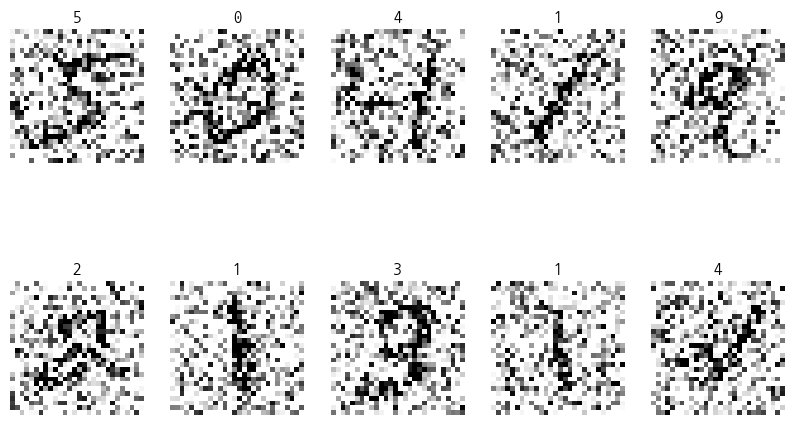

In [9]:
# 오리지널 데이터에 노이즈를 추가한 데이터 시각화
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_noise[i], cmap='Greys')
    plt.axis('off')
    plt.title(y_train[i])
plt.show()

오토 인코더의 인코더 부분으로 사용할 신경망 모델을 만든다.

In [10]:
# 인코더 모델에 추가할 입력 레이어를 만든다.
# Input 레이어의 Output Shape은 shape 속성값을 따른다. (None, 28, 28, 1)
# Input 레이어의 Param 이전 레이어가 없기 때문에 0이다.
input_layer = Input(shape=(28, 28, 1)) # 입력 데이터 1건의 차원을 지정한다.

# 인코더 모델에 추가할 히든 레이어를 만든다.
# filters 속성으로 레이어의 출력 차원을 지정하고 kernel_size 속성으로 커널의 크기를 지정한다.
# padding 속성으로 'same'를 지정해서 패딩을 적용하면 Output Shape이 변경되지 않는다.
# Conv2D 레이어의 Output Shape은 padding 속성값과 filters에 의해서 결정된다.
# padding 속성값이 'valid'면 데이터의 차원이 [입력 데이터의 차원(28) + 1 - 커널의 차원(5)]로 변경된다. (None, 24, 24, 32)
# padding 속성값이 'same'면 데이터의 차원이 변경되지 않는다. (None, 28, 28, 32)
# Conv2D 레이어의 Param은 [커널의 크기 * 입력 채널 크기 * 필터 크기 + 필터마다 1개의 바이어스]로 결정된다.
# 커널의 크기(5 * 5) * 입력 채널 크기(1) * 필터 크기(32) + 필터마다 1개의 바이어스(32) = 25 * 1 * 32 + 32 = 832
conv_layer = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)

# 인코더 모델에 추가할 출력 레이어를 만든다.
# pool_size 속성으로 맥스 풀링을 실행할 픽셀의 크기를 지정한다. 기본값은 (2, 2)이다.
# MaxPooling2D 레이어의 Output Shape [입력 데이터의 차원 / pool_size의 차원]로 결정된다.
# 입력 데이터의 차원(28) / pool_size의 차원(2) = 28 / 2 = 14, (None, 14, 14, 32)
# MaxPooling2D 레이어의 Param은 없으므로 0이다.
output_layer = MaxPool2D(pool_size=(2, 2), padding='same')(conv_layer)

# 인코더 모델을 만든다.
# Model 객체에 입력 레이어와 출력 레이어를 넘겨서 신경망 모델을 만든다.
encoder = Model(input_layer, output_layer)

encoder.summary() # 오토 인코더의 인코더로 사용할 신경망 모델의 구조를 확인한다.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


오토 인코더의 디코더 부분으로 사용할 신경망 모델을 만든다.

In [11]:
print(output_layer.shape)
print(output_layer.shape[1:len(output_layer.shape)])
print(output_layer.shape[1:4])

(None, 14, 14, 32)
(14, 14, 32)
(14, 14, 32)


In [12]:
# 디코더 모델에 추가할 입력 레이어를 만든다.
# 디코더는 인코더의 출력을 입력으로 받아야 하므로 디코더 모델의 Input 레이어에 입력되는 데이터 차원은
# 인코더 모델의 출력 차원과 같다.
# Input 레이어의 Output Shape은 shape 속성값을 따른다. (None, 14, 14, 32)
# Input 레이어의 Param 이전 레이어가 없기 때문에 0이다.
input_layer = Input(shape=output_layer.shape[1:4])

# 디코더 모델에 추가할 히든 레이어를 만든다.
# Conv2D 레이어의 Output Shape은 padding 속성값과 filters에 의해서 결정된다.
# padding 속성값이 'same'면 데이터의 차원이 변경되지 않는다. (None, 14, 14, 10)
# Conv2D 레이어의 Param은 [커널의 크기 * 입력 채널 크기 * 필터 크기 + 필터마다 1개의 바이어스]로 결정된다.
# 커널의 크기(5 * 5) * 입력 채널 크기(32) * 필터 크기(10) + 필터마다 1개의 바이어스(10) = 25 * 32 * 10 + 10 = 8010
conv_layer = Conv2D(filters=10, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)

# 디코더 모델에 줄어들었던 차원을 다시 높여주기 위해서 UpSampling2D 레이어를 만든다.
# UpSampling2D 레이어의 Output Shape은 이미지가 압축되기 전의 차원으로 변환된다. (None, 28, 28, 10)
# UpSampling2D 레이어의 Param은 없으므로 0이다.
conv_layer = UpSampling2D()(conv_layer)

# 디코더 모델에 추가할 출력 레이어를 만든다.
# 최종 출력 채널의 개수는 최초 입력 이미지의 채널 수와 같아야 하므로 filters 속성값을 1로 설정한다.
# Conv2D 레이어의 Output Shape은 padding 속성값과 filters에 의해서 결정된다.
# padding 속성값이 'same'면 데이터의 차원이 변경되지 않는다. (None, 28, 28, 1)
# Conv2D 레이어의 Param은 [커널의 크기 * 입력 채널 크기 * 필터 크기 + 필터마다 1개의 바이어스]로 결정된다.
# 커널의 크기(5 * 5) * 입력 채널 크기(10) * 필터 크기(1) + 필터마다 1개의 바이어스(1) = 25 * 10 * 1 + 1 = 251
output_layer = Conv2D(filters=1, kernel_size=(5, 5), padding='same', activation='relu')(conv_layer)

# 디코더 모델을 만든다.
# Model 객체에 입력 레이어와 출력 레이어를 넘겨서 신경망 모델을 만든다.
decoder = Model(input_layer, output_layer)

decoder.summary() # 오토 인코더의 디코더로 사용할 신경망 모델의 구조를 확인한다.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 14, 32)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 10)        8010      
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         251       
                                                                 
Total params: 8,261
Trainable params: 8,261
Non-trainable params: 0
_________________________________________________________________


인코더 모델과 디코더 모델을 합쳐셔 오토 인코더 신경망 모델을 만든다.

In [13]:
# 오토 인코더는 최초 입력값을 인코더에 먼저 넣고 그 결과로 나온 출력을 디코더에 넣는다.

# 오토 인코더 모델에 추가할 입력 레이어를 만든다.
# Input 레이어의 Output Shape은 shape 속성값을 따른다. (None, 28, 28, 1)
# Input 레이어의 Param 이전 레이어가 없기 때문에 0이다.
input_auto = Input(shape=(28, 28, 1))

# 오토 인코더 모델에 추가할 출력 레이어를 만든다.
# 인코더의 Output Shape은 인코더 신경망 최종 출력의 Output Shape을 따른다. (None, 14, 14, 32)
# 인코더의 Param은 인코더 신경망의 모든 Param을 더한 값을 따른다. 0 + 832 + 0 = 832
# 디코더의 Output Shape은 디코더 신경망 최종 출력의 Output Shape을 따른다. (None, 28, 28, 1)
# 디코더의 Param은 디코더 신경망의 모든 Param을 더한 값을 따른다. 0 + 8010 + 0 = 251 = 8261
output_auto = decoder(encoder(input_auto))

# Model 객체에 입력 레이어와 출력 레이어를 넘겨서 신경망 모델을 만든다.
auto_encoder = Model(input_auto, output_auto)

auto_encoder.summary() # 오토 인코더의 신경망 모델의 구조를 확인한다.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 14, 14, 32)        832       
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         8261      
                                                                 
Total params: 9,093
Trainable params: 9,093
Non-trainable params: 0
_________________________________________________________________


오토 인코더 신경망 모델 컴파일

In [14]:
# compile() 메소드로 생성한 신경망 모델을 컴파일 한다.
# 분류 신경망은 loss 속성에 손실(비용, 오차) 함수를 지정할 때 이진 분류일 경우 'binary_crossentropy'를
# 지정하고, 3개 이상의 클래스로 분류할 경우 'categorical_crossentropy'를 지정한다.
# optimizer 속성에 최적화 함수(일반적으로 adam)를 지정한다.
# metrics 속성에 평가 기준을 지정한다.
auto_encoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

오토 인코더 신경망 모델 학습

In [15]:
# fit() 메소드의 인수로 학습 데이터와 원-핫 인코딩된 학습 데이터에 따른 레이블 및 epochs 속성에 학습 횟수,
# batch_size 속성에 미니 배치 크기를 넘겨서 컴파일된 신경망 모델을 학습시킨다.
history = auto_encoder.fit(x_train_noise, x_train, epochs=10, batch_size=100)

Epoch 1/10
600/600 [==============================] - 73s 121ms/step - loss: 0.0268 - mean_squared_error: 0.0268
Epoch 2/10
600/600 [==============================] - 64s 107ms/step - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 3/10
600/600 [==============================] - 64s 107ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 4/10
600/600 [==============================] - 63s 105ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 5/10
600/600 [==============================] - 63s 105ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 6/10
600/600 [==============================] - 61s 102ms/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 7/10
600/600 [==============================] - 59s 99ms/step - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 8/10
600/600 [==============================] - 61s 102ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 9/10
600/600 [==============================] - 57s 95ms/step - loss: 0.0142 - mean_squared

오토 인코더 신경망 모델 예측

In [16]:
# predict() 메소드로 테스트 피쳐 데이터를 넘겨서 예측값을 계산한다.
predict = auto_encoder.predict(x_train_noise)

1875/1875 [==============================] - 16s 9ms/step


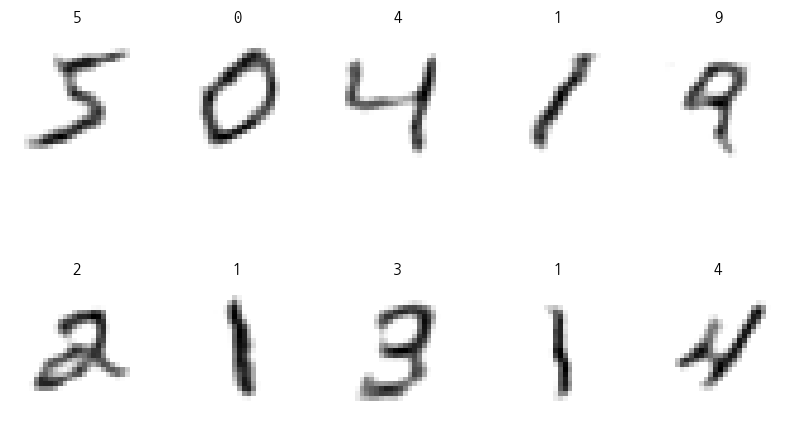

In [17]:
# 오토 인코딩 신경망으로 예측한 노이즈를 추가한 데이터 시각화
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(predict[i], cmap='Greys')
    plt.axis('off')
    plt.title(y_train[i])
plt.show()